In [1]:
# %load debug_raytracing.py
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as cst

import pyc2ray as pc2r
import sys
sys.path.append('../../src/asora_anisotr/')
import libasora_anisotr as asora

from tqdm import tqdm

/usr/local/lib/python3.10/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
2025-03-19 16:18:43.747330: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-19 16:18:43.790307: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-19 16:18:43.790330: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Atte

In [13]:
# # HI cross section at its ionzing frequency (weighted by freq_factor)
sigma_HI_at_ion_freq = np.float64(6.30e-18)

# min and max frequency of the integral
freq_min, freq_max = (13.598*u.eV/cst.h).to('Hz').value, (54.416*u.eV/cst.h).to('Hz').value

# calculate the table
minlogtau, maxlogtau, NumTau = -20.0, 4.0, 20000
tau, dlogtau = pc2r.make_tau_table(minlogtau, maxlogtau, NumTau)

radsource = pc2r.radiation.BlackBodySource(1e5, False, freq_min, sigma_HI_at_ion_freq)
photo_thin_table, photo_thick_table = radsource.make_photo_table(tau, freq_min, freq_max, 1e48)

boxsize, N = 50.*u.pc, 200
dr = (boxsize/N).cgs.value

# number of sources done in parallel on the GPU
source_batch_size = 8

# max distance (in pixel size) that the raytracing is computed
r_RT = 35.0

# allocate GPU memory for the grid and sources batch size
asora.device_init(N, source_batch_size, 0, 1)

# allocate tables to GPU device
asora.photo_table_to_device(photo_thin_table, photo_thick_table, NumTau)

coldensh_out = np.ravel(np.zeros((N, N, N), dtype='float64'))
phi_ion = np.ravel(np.zeros((N, N, N), dtype='float64')) # in ^-1
ndens = np.ravel(1e-3 * np.ones((N, N, N))).astype('float64',copy=True) # g/cm^3
xHII = np.ravel(1e-4 * np.ones((N, N, N))).astype('float64',copy=True)

# copy density field to GPU device
asora.density_to_device(ndens, N)

# efficiency factor (converting mass to photons)
f_gamma, t_s = 100., (3.*u.Myr).cgs.value

nsrc = 3
# define some random sources
srcpos = np.array([[N//2, N//2, N//2]]*nsrc).T
normflux = np.array([f_gamma*1e18/1e48]*nsrc)

#srcpos = np.random.randint(low=N//4, high=N-N//4, size=(3, nsrc))
#normflux = f_gamma*np.random.uniform(low=1e10, high=1e14, size=nsrc)/1e48

#srcpos = np.array([N//2, N//2, N//2])
#srcpos = srcpos[...,None]
#normflux = np.array([f_gamma*1e18/1e48]) #f_gamma*np.random.uniform(low=1e10, high=1e14, size=nsrc)/1e48
#nsrc = len(normflux)

#rad_dir = np.random.uniform(low=0, high=N, size=(3, nsrc))
rad_dir = np.array([[0,1,0], [1,0,0], [0,0,1]], dtype='float64')
rad_dir /= np.linalg.norm(rad_dir, axis=0)
cos_angl = np.cos(np.deg2rad(np.random.uniform(low=5, high=20, size=nsrc)))

#rad_dir = np.array([1., 1., 1.])
#rad_dir = rad_dir[...,None]/np.linalg.norm(rad_dir, axis=0)
#cos_angl = np.array([np.cos(np.deg2rad(45))])

# format the sources conform to the C++ module
srcpos_flat = np.ravel(srcpos.astype('int32', copy=True))
normflux_flat = normflux.astype('float64', copy=True)
rad_dir_flat = np.ravel(rad_dir.astype('float64', copy=True))
cos_angle_flat = cos_angl.astype('float64', copy=True)

# copy source list to GPU device
asora.source_data_to_device(srcpos_flat, normflux_flat, rad_dir_flat, cos_angle_flat, nsrc)

asora.do_all_sources(r_RT, coldensh_out, sigma_HI_at_ion_freq, dr, ndens, xHII, phi_ion, nsrc, N, minlogtau, dlogtau, NumTau)

Number of GPUS 1
GPU Device ID 0: "NVIDIA RTX A1000 6GB Laptop GPU" with compute capability 8.6
Successfully allocated 704 Mb of device memory for grid of size N = 200, with source batch size 8


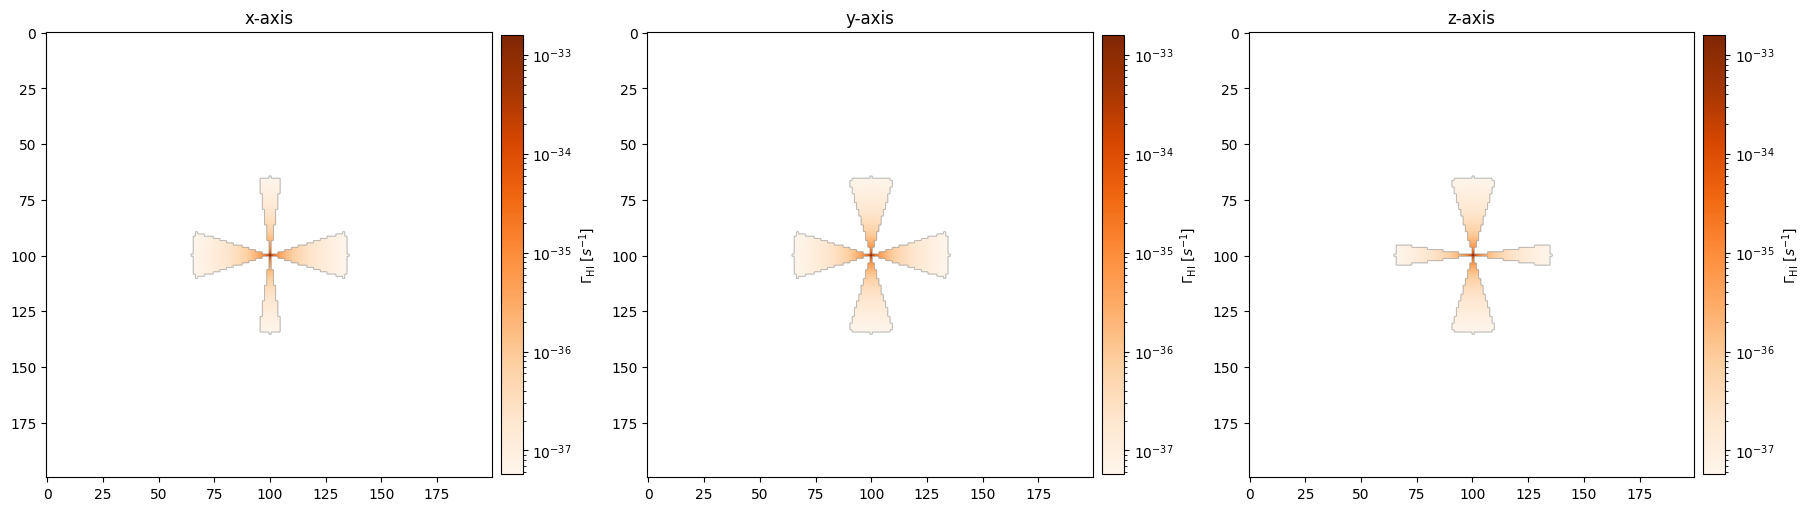

1.586073302529185e-33 (array([100]), array([100]), array([100]))


<Figure size 640x480 with 0 Axes>

In [14]:
fig, axs = plt.subplots(figsize=(18, 5), nrows=1, ncols=3, constrained_layout=True)

phi = phi_ion.reshape(N,N,N)

axs[0].set_title('x-axis')
im = axs[0].imshow(phi[N//2], norm='log', cmap='Oranges')
plt.colorbar(im, ax=axs[0], label=r'$\Gamma_\mathrm{HI}$ [$s^{-1}$]', pad=0.02, fraction=0.048)
axs[1].set_title('y-axis')
im = axs[1].imshow(phi[:,N//2,:], norm='log', cmap='Oranges')
plt.colorbar(im, ax=axs[1], label=r'$\Gamma_\mathrm{HI}$ [$s^{-1}$]', pad=0.02, fraction=0.048)
axs[2].set_title('z-axis')
im = axs[2].imshow(phi[...,N//2], norm='log', cmap='Oranges')
plt.colorbar(im, ax=axs[2], label=r'$\Gamma_\mathrm{HI}$ [$s^{-1}$]', pad=0.02, fraction=0.048)
plt.show(), plt.clf()

print(phi.max(), np.where((phi == phi.max())))

In [15]:
path_out = '/home/mbianco/Downloads/plots/'

from mayavi import mlab
mlab.init_notebook()

data = np.array(phi>phi.min(), dtype=int)
# create emtpy image
f0 = mlab.figure(size=(1200, 1000), fgcolor=(1,1,1), bgcolor=(0.,0.,0.))
src = mlab.pipeline.scalar_field(data)
#vol = mlab.pipeline.volume(src, vmin=1e-37, vmax=1e-35, color=(1,1,1))
vol = mlab.pipeline.volume(src, vmin=0, vmax=1, color=(1,1,1))
mlab.outline()
mlab.view(azimuth=-120, elevation=70, distance=300, focalpoint=[N//2, N//2, N//2])
mlab.savefig('%stest.png' %(path_out))          

Notebook initialized with ipy backend.


In [16]:
vol

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x04\xb0\x00\x00\x03\xe8\x08\x02\x00\x00\x00A9\x90\x8…

In [6]:
path_out = '/home/mbianco/Downloads/plots/'
phi = np.linspace(-180, 180, 200, endpoint=False) # fast inital rotation

# create emtpy image
f0 = mlab.figure(size=(1200, 1000), fgcolor=(1,1,1), bgcolor=(0.,0.,0.))
src = mlab.pipeline.scalar_field(data)

for i in tqdm(range(phi.size)):
    mlab.clf()
    vol = mlab.pipeline.volume(src, vmin=1e-37, vmax=1e-35, color=(1,1,1))
    mlab.outline()
    mlab.view(azimuth=phi[i], elevation=70, distance=600, focalpoint=[N//2, N//2, N//2])
    mlab.draw()
    mlab.savefig('%st%03d.png' %(path_out, i))          

 14%|█████▍                                 | 28/200 [22:30<5:30:53, 115.43s/it]Exception
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/mayavi/core/source.py", line 123, in start
    obj.start()
  File "/usr/local/lib/python3.10/dist-packages/mayavi/core/module_manager.py", line 175, in start
    obj.start()
  File "/usr/local/lib/python3.10/dist-packages/mayavi/modules/volume.py", line 305, in start
    super(Volume, self).start()
  File "/usr/local/lib/python3.10/dist-packages/mayavi/core/module.py", line 130, in start
    super(Module, self).start()
  File "/usr/local/lib/python3.10/dist-packages/mayavi/core/pipeline_base.py", line 92, in start
    self.add_actors()
  File "/usr/local/lib/python3.10/dist-packages/mayavi/core/pipeline_base.py", line 142, in add_actors
    scene.add_actors(self.actors)
  File "/usr/local/lib/python3.10/dist-packages/tvtk/pyface/tvtk_scene.py", line 277, in add_actors
    self.render()
  File "/usr/local/lib/python3

ValueError: not enough values to unpack (expected 2, got 0)

In [ ]:
from moviepy.editor import ImageSequenceClip

def CreateMovie(filename, array, fps=5, scale=1., fmt='avi'):
    ''' Create and save a gif or video from array of images.
        Parameters:
            * filename (string): name of the saved video
            * array (list or string): array of images name already in order, if string it supposed to be the first part of the images name (before iteration integer)
            * fps = 5 (integer): frame per seconds (limit human eye ~ 15)
            * scale = 1. (float): ratio factor to scale image hight and width
            * fmt (string): file extention of the gif/video (e.g: 'gif', 'mp4' or 'avi')
        Return:
            * moviepy clip object
    '''
    if(isinstance(array, str)):
        array = np.array(sorted(glob(array+'*.png'), key=os.path.getmtime))
    else:
        pass
    filename += '.'+fmt
    clip = ImageSequenceClip(list(array), fps=fps).resize(scale)
    if(fmt == 'gif'):
        clip.write_gif(filename, fps=fps)
    elif(fmt == 'mp4'):
        clip.write_videofile(filename, fps=fps, codec='mpeg4')
    elif(fmt == 'avi'):
        clip.write_videofile(filename, fps=fps, codec='png')
    else:
        print('Error! Wrong File extension.')
        sys.exit()

    # print the size of the movie
    command = os.popen('du -sh %s' % filename)
    print(command.read())
    return clip

In [ ]:
img_arr = ['%st%03d.png' %(path_out, i) for i in range(len(glob(path_out+'t*png')))]
#CreateMovie(filename='movie_HI_IGM_EoR', array=img_arr, fps=15, fmt='avi')
CreateMovie(filename='movie_HI_IGM_EoR', array=img_arr, fps=15, fmt='mp4')

In [28]:
asora.device_close()